# Generate the data
Downloads the poster images and saved a new csv file with the data

In [ ]:
data_path = "../data/"
poster_data_path = data_path + "movie-genre-from-its-poster/MovieGenre.csv"
new_poster_data_file = "New_poster_data.csv"
base_images_path = "../data/images/100/"

In [ ]:
import pandas as pd 
# Read data from file 'MovieGenre.csv' 
poster_data = pd.read_csv(poster_data_path, encoding = "ISO-8859-1", usecols=['imdbId', 'Genre', 'Title', 'Poster']) 

# Preview the first 5 lines of the loaded data 
poster_data.head()

In [ ]:
len(poster_data)

Remove lines with empty cells

In [ ]:
import numpy as np
cols=['imdbId', 'Genre', 'Title', 'Poster']
for i in cols:
    poster_data[i].replace('', np.nan, inplace=True)
for i in cols:
    poster_data.dropna(subset=[i], inplace=True)
    
len(poster_data)

### Download movie posters
Check if the poster has a valid url. If the poster is found, download it and save the movie titles and genres to a new file. If the image is already downloaded and found in the folder, the download is skipped.

In [ ]:
import urllib.request
from urllib.error import HTTPError
import os.path

def download_posters(poster_url, path, title):
    if os.path.isfile(path+".jpg"):
        print ("Poster", title ,"exist")
    else:
        try:
            urllib.request.urlretrieve(poster_url, path+".jpg")
        except HTTPError:
            print("Movie",title ,"poster not found!")
            return False
    return True

In [ ]:
import re

new_poster_data = pd.DataFrame(columns=['imgid', 'title', 'genres'])

for _, row in poster_data.iterrows(): 
    genre = str(row['Genre'])
    genres = str(row['Genre']).split("|")
    genres = (", ").join(genres)
    title = str(row['Title'])
    img_id = str(row['imdbId'])    
    # remove years from titles
    title = re.sub(" \(\d{4,}\)", "",  title)
    poster_url = str(row['Poster'])
    
    # download the poster
    poster = download_posters(poster_url, base_images_path+img_id, title)
    
    not_found = 0
    # if poster is not found, skip movie
    if poster == True:
        new_row = {'imgid':img_id ,'title':title, 'genres':genres}    
        new_poster_data = new_poster_data.append(new_row, ignore_index=True) 
    else:
        not_found += 1

print("{} posters not found".format(not_found))

In [ ]:
new_poster_data.head()

In [ ]:
new_poster_data.to_csv(data_path+new_poster_data_file,index=False)

## Start vectorization (run from here after downloading img)

In [29]:
data_path = "../data/"
poster_data_path = data_path + "movie-genre-from-its-poster/MovieGenre.csv"
new_poster_data_file = "New_poster_data.csv"
base_images_path = "../data/images/100/"

In [30]:
import pandas as pd 
# Read data from file 'MovieGenre.csv' 
new_poster_data = pd.read_csv(data_path+new_poster_data_file, encoding = "ISO-8859-1", usecols=['imgid', 'title', 'genres']) 

# Preview the first 5 lines of the loaded data 
new_poster_data.head()

,imgid,title,genres
0,114709,Toy Story,"Animation, Adventure, Comedy"
1,113497,Jumanji,"Action, Adventure, Family"
2,113228,Grumpier Old Men,"Comedy, Romance"
3,114885,Waiting to Exhale,"Comedy, Drama, Romance"
4,113041,Father of the Bride Part II,"Comedy, Family, Romance"


In [31]:
len(new_poster_data)

37742

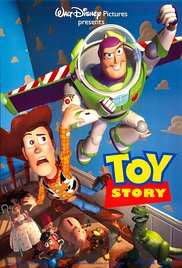

In [32]:
from IPython.display import Image
image = Image(base_images_path+'/114709.jpg')
image

## Movie title tokenization

You would need a one-layer LSTM with a pre-trained sub-word embedding, + feature fusion layer (concatenate each subword embedding with poster visual vector or its genre vector).
Then, train the LSTM on movie titles, when you have visual vectors.


In [33]:
# loading vectors from disk
#from gensim.models import KeyedVectors
#from gensim.test.utils import datapath

#vectors_path = "../data/bpemb/data/en/"
#model_path = vectors_path+"en.wiki.bpe.vs50000.d300.w2v.bin"

#wv_from_bin = KeyedVectors.load_word2vec_format((model_path), binary=True)  # C bin format

In [34]:
from bpemb import BPEmb

If/how a word gets split depends on the vocabulary size. Generally, a smaller vocabulary size will yield a segmentation into many subwords, while a large vocabulary size will result in frequent words not being split. The advantage of having few operations is that this results in a smaller vocabulary of symbols. You need less data to learn representations (embeddings) of these symbols. The disadvantage is that you need data to learn how to compose those symbols into meaningful units (e.g. words).
I chose the smallest vocabulary since the larger ones would not split any titles at all.

In [35]:
#bpemb_en = BPEmb(lang="en", dim=300, vs=100000)
bpemb_en = BPEmb(lang="en", dim=100, vs=1000)

In [36]:
bpemb_en.encode("Toy Story")

['▁to', 'y', '▁st', 'ory']

In [37]:
# look at some examples
for _,row in new_poster_data[:10].iterrows():

    title = str(row['title'])
    print(title, bpemb_en.encode(title))

Toy Story ['▁to', 'y', '▁st', 'ory']
Jumanji ['▁j', 'um', 'an', 'j', 'i']
Grumpier Old Men ['▁gr', 'um', 'p', 'ier', '▁old', '▁m', 'en']
Waiting to Exhale ['▁w', 'a', 'it', 'ing', '▁to', '▁ex', 'h', 'ale']
Father of the Bride Part II ['▁f', 'ather', '▁of', '▁the', '▁br', 'ide', '▁part', '▁i', 'i']
Heat ['▁he', 'at']
Sabrina ['▁s', 'ab', 'r', 'ina']
Sudden Death ['▁s', 'ud', 'd', 'en', '▁de', 'ath']
GoldenEye ['▁g', 'old', 'en', 'e', 'y', 'e']
The American President ['▁the', '▁american', '▁pres', 'ident']


In [38]:
bpemb_en.most_similar("ory")

[('▁hist', 0.6690595149993896),
 ('ict', 0.6023141741752625),
 ('ical', 0.45034170150756836),
 ('raph', 0.42858463525772095),
 ('rit', 0.4229355454444885),
 ('ics', 0.40942496061325073),
 ('▁book', 0.39245858788490295),
 ('the', 0.3671647906303406),
 ('or', 0.35785210132598877),
 ('▁art', 0.3448060154914856)]

In [39]:
def generate_embeddings(movie_title):
    #ids = bpemb_en.encode_ids(movie_title)
    #emb = bpemb_en.vectors[ids].shape
    emb = bpemb_en.embed(movie_title)
    return emb

In [40]:
emb = generate_embeddings("Grumpier Old Men")
emb.shape

(7, 100)

## Get image feature vectors

In [41]:
import torch
data_path = "../data/"
poster_data_path = data_path + "movie-genre-from-its-poster/MovieGenre.csv"
new_poster_data_file = "New_poster_data.csv"
base_images_path = "../data/images/100/"

model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet152', pretrained=True)
layer = model._modules.get('avgpool')
model.eval()

Using cache found in /home/gusihaliel@GU.GU.SE/.cache/torch/hub/pytorch_vision_v0.4.2


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#scaler = transforms.Scale((224, 224))
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

to_tensor = transforms.ToTensor()

def get_img_vector(image_name):
    # Load the image with Pillow library
    img = Image.open(image_name)    
    # Check if the imge is in colour
    img_bands = img.getbands()    
    
    if len(img_bands) < 3:     
        img = Image.new("RGB", img.size)
    # Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))  
        
    #  Create a vector of zeros that will hold the feature vector
    #  The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)    
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        #my_embedding.copy_(o.data) # original code not working
        my_embedding.copy_(o.data.squeeze())        
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        t_img = t_img.to(device)
        model.to(device)
    #  Attach that function to our selected layer   
    h = layer.register_forward_hook(copy_data)    
    #  Run the model on our transformed image
    model(t_img)    
    #  Detach our copy function from the layer
    h.remove()    
    #  Return the feature vector
    return my_embedding


In [22]:
# create a vocab
def get_vocab(new_poster_data):
    all_titles=[]
    for _,row in new_poster_data.iterrows():
        title = str(row['title'])
        encoded = bpemb_en.encode(title)
        [all_titles.append(token) for token in encoded]
    # create a vocabulary
    vocab = {f:i+4 for i,f in enumerate((set(all_titles)))}    
    # reserved tokens    
    vocab["<unk>"] = 0  # unknown words (this was already defined in the model)
    vocab["<pad>"] = 1 # padding
    vocab["<s>"] = 2  # title starting tag
    vocab["<e>"] = 3  # title ending tag
        
    return vocab

# mapping tokens to integers
token_to_int = get_vocab(new_poster_data)  
# reverse mapping
int_to_str = {v: k for k, v in token_to_int.items()}

In [23]:
# add the start and end tokens somewhere here

In [55]:
base_images_path = "../data/images/100/"
import numpy as np

# create a list of embeddings for each title, 
# each of size [512]+[100]
def get_both_vectors(row):    
    vectors = [] 

    img = str(row['imgid'])
    path = base_images_path + img +".jpg"      
    img_vector = get_img_vector(path)

    title = str(row['title'])
    # tokenize title
    token_ids = bpemb_en.encode_ids(title)
    for t in token_ids:            
        token_vec = bpemb_en.vectors[t]       
        token_tensor = torch.from_numpy(token_vec)
        concat_vec = torch.cat((token_tensor, img_vector),0) # cat 0 or 1?
        vectors.append(concat_vec)
        
    return vectors

In [56]:
from torch.utils.data import Dataset
from torch.utils import data

class MoviePosterDataset(Dataset):
    def __init__(self, title, vectors,):
        self.title = title
        self.vectors = vectors

    def __len__(self):
        return len(self.title)
    
    def __getitem__(self, idx):            
        title = self.title[idx]
        vectors = self.vectors[idx]
                
        return title, vectors

In [57]:
titles=[]
vectors = [] # the concatenated vectors

for _,row in new_poster_data.iterrows():  
    t = str(row['title'])    
    vec = get_both_vectors(row)
    titles.append(t)
    vectors.append(vec)
    
movies_dataset = MoviePosterDataset(titles, vectors)

In [60]:
import random
import math

totalindices = list(range(len(titles)))
random.shuffle(totalindices)
splitindex = math.floor(len(titles)*0.6)
trainindices = totalindices[:splitindex]
testindices_ = totalindices[splitindex:]
splitindex2 = math.floor(len(testindices_)*0.5)
testindices = testindices_[:splitindex2]
valindices = testindices_[splitindex2:]

In [61]:
trainingsampler = torch.utils.data.SubsetRandomSampler(trainindices)
testingsampler = torch.utils.data.SubsetRandomSampler(testindices)
validationsampler = torch.utils.data.SubsetRandomSampler(valindices)

In [62]:
print(f'Number of training examples: {len(trainingsampler)}')
print(f'Number of validation examples: {len(validationsampler)}')
print(f'Number of testing examples: {len(testingsampler)}')

Number of training examples: 22645
Number of validation examples: 7549
Number of testing examples: 7548


In [63]:
batches = 1

In [64]:
traindl = torch.utils.data.DataLoader(movies_dataset, batch_size=batches, 
                                      sampler=trainingsampler, pin_memory=False)
valdl = torch.utils.data.DataLoader(movies_dataset, batch_size=batches, sampler=validationsampler, pin_memory=False)
testdl = torch.utils.data.DataLoader(movies_dataset, sampler=testingsampler)